In [216]:
import pandas as pd
from fastai.imports import *     # We are data scientists prototyping models. This is not production code!  # Importing everything and having everything available is quicker and more useful

#from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from IPython.display import display
from scipy.cluster import hierarchy as hc

from sklearn import metrics
import torch
import phik
from sklearn.tree import export_graphviz
import graphviz
from subprocess import call
import os

In [20]:
def display_all(df):
    with pd.option_context("display.max_rows", 5000, "display.max_columns", 2000): 
        display(df)

In [21]:
df = pd.read_csv('training_input (IQVIA derivation dataset).csv', low_memory = False)

In [22]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=20, oob_score=True)

try:
    m.fit(df.drop(['cohort_flag','cohort_type'], axis=1), df.cohort_flag)
    print(m.score(df.drop(['cohort_flag','cohort_type'], axis=1),df.cohort_flag))
    print(m.oob_score_)

except (ValueError) as e:
    print(e)

0.9373202614379085
0.5557271897969494


In [23]:
for n,c in df.items():
        if pd.api.types.is_integer_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [60]:
df.cohort_flag.cat.categories

Int64Index([0, 1], dtype='int64')

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
x = df.drop(['cohort_flag','cohort_type','patient_id'],axis=1)
y = df.cohort_flag

In [26]:
train_df_x,test_df_x,train_y, test_y = train_test_split(x,y,test_size=0.2,random_state = 10)
print(train_df_x.shape), print(test_df_x.shape)

(1713, 1874)
(429, 1874)


(None, None)

In [178]:
features = []
tresholds = []
for i in range(1,11):
    m = DecisionTreeClassifier(max_depth= None, max_features = None, criterion = "entropy", splitter = 'random')
    m.fit(train_df_x.drop(potential_leaks,axis=1), train_y)
    imp =  pd.DataFrame(pd.DataFrame([train_df_x.drop(potential_leaks,axis=1).columns,m.feature_importances_]).transpose())
    imp = imp.rename(columns={0:'feature',1:'importance'})
    imp = imp.sort_values('importance',ascending = False)
    imp['iteration']=1
    imp['threshold']=m.tree_.threshold[0]
    features.append(m.tree_.feature[0])
    tresholds.append(m.tree_.threshold[0])

Wall time: 991 µs
1.0
0.8275058275058275
                                                           feature importance
258                cardiomyopathy_in_diseases_classified_elsewhere   0.434194
255                                                 cardiomyopathy  0.0364247
292                   chronic_diastolic__congestive__heart_failure   0.017322
809                                        ischemic_cardiomyopathy  0.0156493
262                 carpal_tunnel_syndrome__unspecified_upper_limb  0.0128474
1539                           pulmonary_hypertension__unspecified  0.0119875
1719                                      type_1_diabetes_mellitus  0.0111212
308   chronic_obstructive_pulmonary_disease_w__acute__exacerbation  0.0108756
1731                   type_2_diabetes_mellitus_with_hyperglycemia  0.0104485
488                                edema__not_elsewhere_classified   0.010251


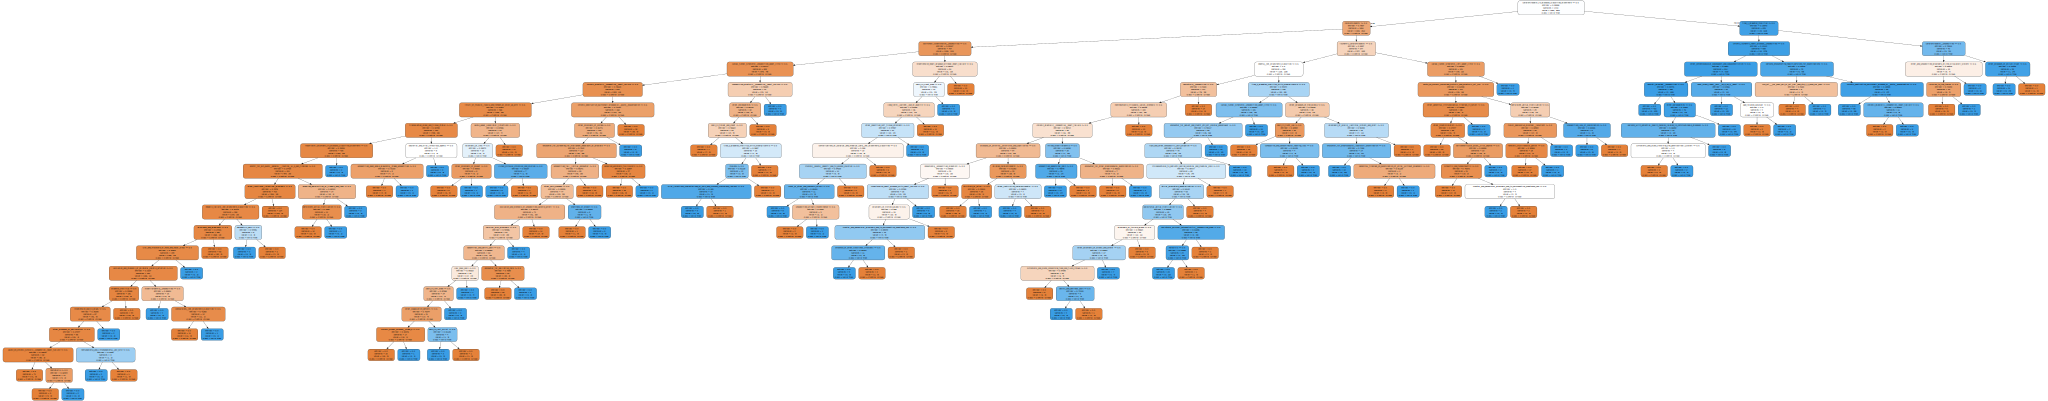

In [202]:
features = []
tresholds = []
%time m = DecisionTreeClassifier(max_depth= None, max_features = None, criterion = "entropy", splitter = 'best')

#potential_leaks = ['cardiomyopathy_in_diseases_classified_elsewhere','cardiomyopathy','cardiomyopathy__unspecified','acute_on_chronic_combined_systolic_and_diastolic_hrt_fail','persistent_atrial_fibrillation']
potential_leaks = []

m.fit(train_df_x.drop(potential_leaks,axis=1), train_y)
print(m.score(train_df_x.drop(potential_leaks,axis=1), train_y))
print(m.score(test_df_x.drop(potential_leaks,axis=1), test_y))
imp =  pd.DataFrame(pd.DataFrame([train_df_x.drop(potential_leaks,axis=1).columns,m.feature_importances_]).transpose())
imp = imp.rename(columns={0:'feature',1:'importance'})
imp = imp.sort_values('importance',ascending = False)
print(imp[:10])
features.append(m.tree_.feature[0])
tresholds.append(m.tree_.threshold[0])

#print(m.oob_score_)



# Export as dot file
estimator = m
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = list(train_df_x.drop(potential_leaks,axis=1).columns),
                class_names = ['Control Group','Wild Type'],
                rounded = True, proportion = False, 
                impurity=True,
                precision = 5, filled = True)

# Convert to png using system command (requires Graphviz)

!dot -Tpng tree.dot -o tree.png
graphviz.Source.from_file('tree.dot')


In [227]:
to_keep = list(imp[0:100]['feature'])

In [191]:
cardio_i_d_c_e = 0.99998*1713 - 0.7807*1084 - 0.19543*629
cardio = 0.7807*1084 - 707*0.59167 - 0.9697*377
diab = 0.19543* 629 - 0.12412*589 - 0.76919*40

In [192]:
cardio_i_d_c_e+cardio+diab

825.2038699999998

In [193]:
cardio_i_d_c_e/(cardio_i_d_c_e+cardio+diab)

0.9013063280956257

In [195]:
cardio/(cardio_i_d_c_e+cardio+diab)

0.07560702544935945

In [196]:
diab/(cardio_i_d_c_e+cardio+diab)

0.023086646455014802

Wall time: 0 ns
0.8423817863397548
0.8251748251748252


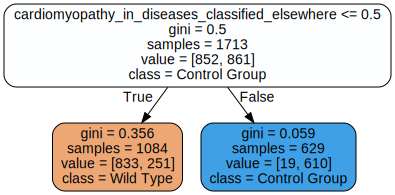

In [201]:
%time m = RandomForestClassifier(n_jobs=-1, n_estimators=1,oob_score=False, max_depth= 1, max_features = None, bootstrap = False)

m.fit(train_df_x, train_y)
print(m.score(train_df_x, train_y))
print(m.score(test_df_x, test_y))
#print(m.oob_score_)

from sklearn.tree import export_graphviz
import graphviz
# Export as dot file
estimator = m.estimators_[0]
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = list(train_df_x.columns),
                class_names = ['Wild Type','Control Group'],
                rounded = True, proportion = False, 
                impurity=True,
                precision = 3, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
!dot -Tpng tree.dot -o tree.png
graphviz.Source.from_file('tree.dot')


In [228]:
%time corr = phik.phik_matrix(train_df_x[to_keep])

Wall time: 32.5 s


In [245]:
corr_condensed

array([0.40039124, 0.57476205, 1.        , ..., 0.90130605, 0.92087634,
       1.        ])

In [240]:
#corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4) # correlation matrix
corr_condensed = hc.distance.squareform(1-corr)                # distances matrix
z = hc.linkage(corr_condensed, method='average')               # hierarchical/agglomerative clustering

fig = plt.figure(figsize=(50,200))
dendrogram = hc.dendrogram(z, labels=train_df_x[to_keep].columns, orientation='left', leaf_font_size=50)
plt.show()

In [114]:
train_df_x.to_csv('train.csv')

In [115]:
train_y.to_csv('train_y.csv')

In [64]:
_clf_base_predictions = m.predict(test_df_x)
clf_base_predictions = pd.Series(data = _clf_base_predictions, name='predicted_value',index = test_df_x.index )

In [65]:
print(metrics.accuracy_score(test_y,clf_base_predictions))
print(metrics.f1_score(test_y,clf_base_predictions))
print(metrics.recall_score(test_y,clf_base_predictions))
print(metrics.precision_score(test_y,clf_base_predictions))
print(metrics.classification_report(test_y,clf_base_predictions))
print(metrics.confusion_matrix(test_y,clf_base_predictions))
print(metrics.roc_auc_score(test_y,clf_base_predictions))

0.8041958041958042
0.7951219512195122
0.7761904761904762
0.815
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       219
           1       0.81      0.78      0.80       210

    accuracy                           0.80       429
   macro avg       0.80      0.80      0.80       429
weighted avg       0.80      0.80      0.80       429

[[182  37]
 [ 47 163]]
0.8036203522504892


In [ ]:
f1_scores = np.array([])
feature_importances_df = pd.DataFrame()
%time 
#for max_dep in range(1,101):
for n_estimator in range(1,30):
    m = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimator,oob_score=False, max_depth= None, max_features = 0.2, bootstrap =False)
    if (max_dep%10==0): print(f'{(max_dep/100)*100}% completed')
    m.fit(train_df_x, train_y)
    _clf_base_predictions = m.predict(test_df_x)
    clf_base_predictions = pd.Series(data = _clf_base_predictions, name='predicted_value',index = test_df_x.index )
    #plt.plot(metrics.f1_score(test_y,clf_base_predictions))
    if f1_scores.size == 0:
        f1_scores = metrics.f1_score(test_y,clf_base_predictions)
        print(f1_scores)
        feature_importances_df = pd.DataFrame(pd.DataFrame([train_df_x.columns,m.feature_importances_]).transpose())
        feature_importances_df = feature_importances_df.rename(columns={0:'feature',1:'importance'})
        #feature_importances_df['max_depth'] = 50
        feature_importances_df['n_estimators'] = n_estimator
        feature_importances_df = feature_importances_df.sort_values('importance',ascending = False)
        print(feature_importances_df[:1])
    else:
        f1_scores = np.append(f1_scores,metrics.f1_score(test_y,clf_base_predictions))
        temp_df = pd.DataFrame(pd.DataFrame([train_df_x.columns,m.feature_importances_]).transpose())
        temp_df = temp_df.rename(columns={0:'feature',1:'importance'})
        #temp_df['max_depth'] = max_dep
        temp_df['n_estimators'] = n_estimator
        temp_df = temp_df.sort_values('importance',ascending = False)
        print(temp_df[:1])
        feature_importances_df = feature_importances_df.append(temp_df)
    

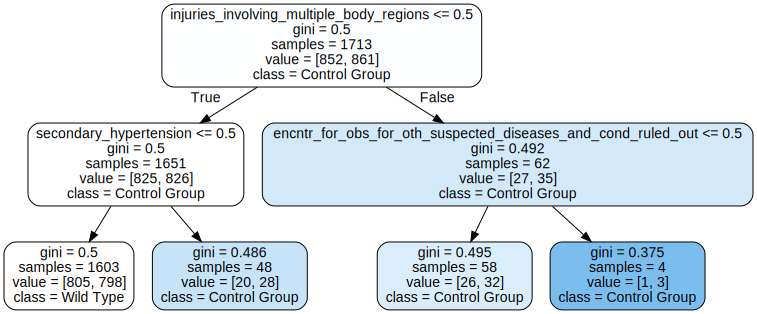

In [90]:
from sklearn.tree import export_graphviz
import graphviz
# Export as dot file
estimator = m.estimators_[0]
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = list(train_df_x.columns),
                class_names = ['Wild Type','Control Group'],
                rounded = True, proportion = False, 
                impurity=True,
                precision = 3, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
!dot -Tpng tree.dot -o tree.png
graphviz.Source.from_file('tree.dot')

In [74]:
imp =  pd.DataFrame(pd.DataFrame([train_df_x.columns,estimator.feature_importances_]).transpose())
imp = imp.rename(columns={0:'feature',1:'importance'})
imp = imp.sort_values('importance',ascending = False)
print(imp[:10])

                                                          feature importance
1397                                       paroxysmal_tachycardia   0.453194
1784                                         unspecified_dementia   0.425474
1434  persons_encountering_health_services_in_other_circumstances   0.121331
0                                       abdominal_and_pelvic_pain          0
1246             other_nonspecific_abnormal_finding_of_lung_field          0
1257                                  other_postprocedural_states          0
1256                                     other_pleural_conditions          0
1255                           other_peripheral_vascular_diseases          0
1254                                           other_pancytopenia          0
1253                                           other_osteopathies          0


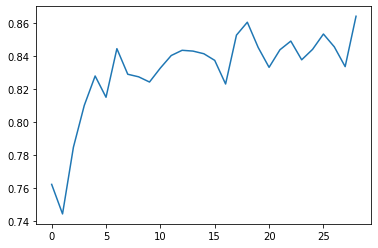

In [329]:
plt.plot(f1_scores)

In [289]:
feature_importances_df[feature_importances_df['max_depth']==6]

,feature,importance,max_depth
258,cardiomyopathy_in_diseases_classified_elsewhere,0.0599089,6
255,cardiomyopathy,0.0356901,6
256,cardiomyopathy__unspecified,0.0243029,6
75,acute_on_chronic_combined_systolic_and_diastolic_hrt_fail,0.0181112,6
692,hyp_hrt___chr_kdny_dis_w_hrt_fail_and_stg_1_4_unsp_chr_kdny,0.0116119,6
...,...,...,...
1012,oth_aplastic_anemias_and_other_bone_marrow_failure_syndromes,0,6
1015,oth_contact_w_and__suspected__exposures_hazardous_to_health,0,6
1601,segmental_and_somatic_dysfunction_of_pelvic_region,0,6
1021,oth_disorders_of_nervous_system_in_diseases_classd_elswhr,0,6


In [373]:

from phik import resources, report

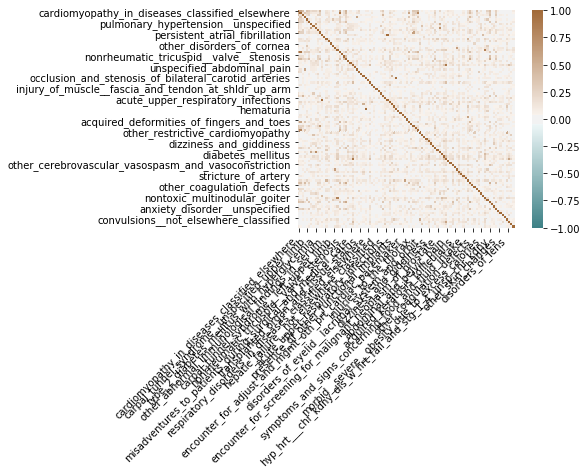

In [235]:
import seaborn as sns

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(2000, 2200, n=20000),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [287]:
import statistics
x = pd.DataFrame(feature_importances_df.groupby('feature')['importance'].sum()/100).sort_values('importance',ascending = False)

In [267]:
x = x[x['importance']>0].head(10).reset_index()

In [268]:
x['feature']

0                cardiomyopathy_in_diseases_classified_elsewhere
1                                                 cardiomyopathy
2                                    cardiomyopathy__unspecified
3      acute_on_chronic_combined_systolic_and_diastolic_hrt_fail
4    hyp_hrt___chr_kdny_dis_w_hrt_fail_and_stg_1_4_unsp_chr_kdny
5                   chronic_diastolic__congestive__heart_failure
6                               disorders_of_synovium_and_tendon
7                                 paroxysmal_atrial_fibrillation
8                                       type_2_diabetes_mellitus
9                                     unspecified_atrial_flutter
Name: feature, dtype: object

In [271]:
feature_importances_df[feature_importances_df['feature']=='cardiomyopathy_in_diseases_classified_elsewhere']['importance'].unique()

array([0.0, 0.05990887166568433], dtype=object)

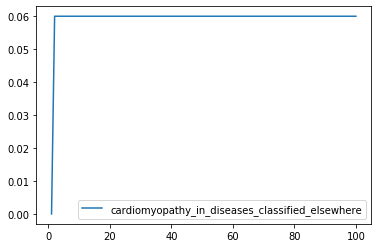

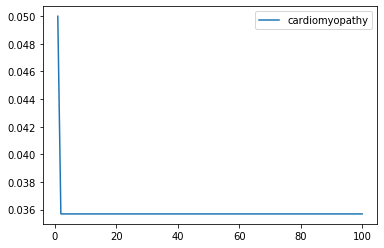

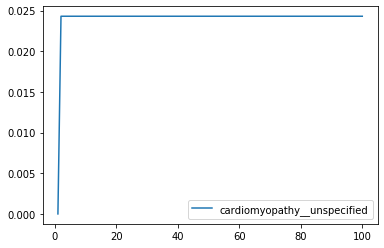

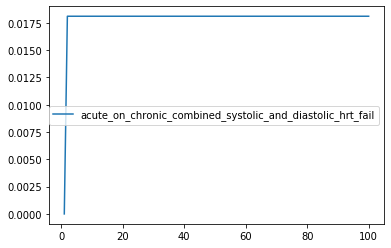

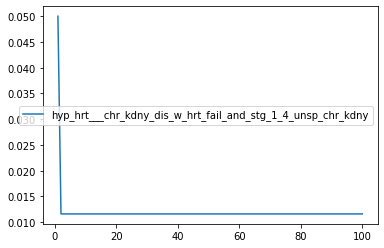

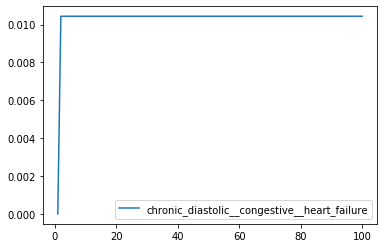

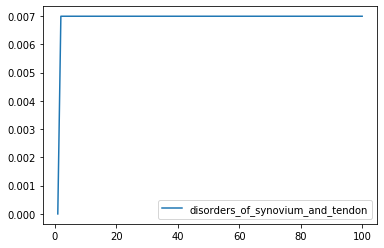

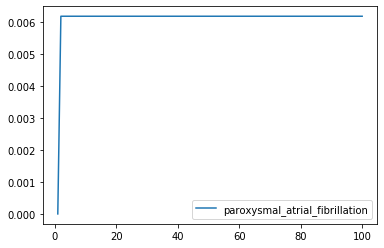

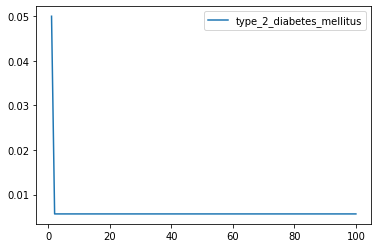

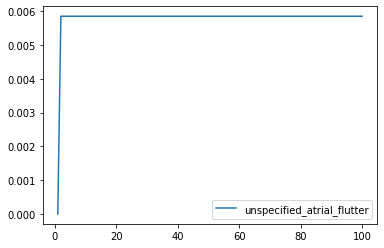

In [269]:
for features in x['feature']:
    temp = feature_importances_df[feature_importances_df['feature']==features]
    plt.plot(temp['max_depth'],temp['importance'],label = features )
    plt.legend()
    plt.show()

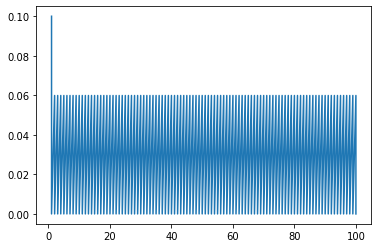

In [225]:
plt.plot(feature_importances_df['max_depth'],feature_importances_df['importance'],label = feature_importances_df['feature'] )

In [123]:
preds = np.stack([t.predict(test_df_x) for t in m.estimators_])
#preds[:,0], np.mean(preds[:,0]), test_y[0]

In [164]:
pd.DataFrame(preds)

,0,1,2,3,4,5,6,7,8,9,...,419,420,421,422,423,424,425,426,427,428
0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
4,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
5,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
6,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
8,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
9,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0


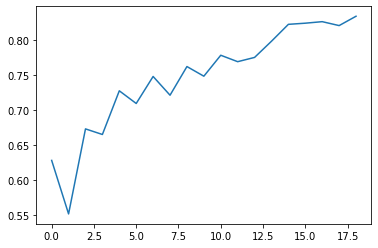

In [171]:
plt.plot([metrics.f1_score(test_y, np.round(np.mean(preds[:i+1], axis=0))) for i in range(19)]);

In [ ]:
def proc_df(df, y_fld, skip_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):

    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe.
    Parameters:
    -----------
    df: The data frame you wish to process.
    y_fld: The name of the response variable
    skip_flds: A list of fields that dropped from df.
    do_scale: Standardizes each column in df,Takes Boolean Values(True,False)
    na_dict: a dictionary of na columns to add. Na columns are also added if there
        are any missing values.
    preproc_fn: A function that gets applied to df.
    max_n_cat: The maximum number of categories to break into dummy values, instead
        of integer codes.
    subset: Takes a random subset of size subset from df.
    mapper: If do_scale is set as True, the mapper variable
        calculates the values used for scaling of variables during training time(mean and standard deviation).
    Returns:
    --------
    [x, y, nas, mapper(optional)]:
        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.
        y: y is the response variable
        nas: returns a dictionary of which nas it created, and the associated median.
        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continous
        variables which is then used for scaling of during test-time.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> x, y, nas = proc_df(df, 'col1')
    >>> x
       col2
    0     1
    1     2
    2     1
    >>> data = DataFrame(pet=["cat", "dog", "dog", "fish", "cat", "dog", "cat", "fish"],
                 children=[4., 6, 3, 3, 2, 3, 5, 4],
                 salary=[90, 24, 44, 27, 32, 59, 36, 27])
    >>> mapper = DataFrameMapper([(:pet, LabelBinarizer()),
                          ([:children], StandardScaler())])
    >>>round(fit_transform!(mapper, copy(data)), 2)
    8x4 Array{Float64,2}:
    1.0  0.0  0.0   0.21
    0.0  1.0  0.0   1.88
    0.0  1.0  0.0  -0.63
    0.0  0.0  1.0  -0.63
    1.0  0.0  0.0  -1.46
    0.0  1.0  0.0  -0.63
    1.0  0.0  0.0   1.04
    0.0  0.0  1.0   0.21
    """
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    df = df.copy()
    if preproc_fn: preproc_fn(df)
    y = df[y_fld].values
    df.drop(skip_flds+[y_fld], axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    res = [pd.get_dummies(df, dummy_na=True), y, na_dict]
    if do_scale: res = res + [mapper]
    return res


In [446]:
rand_idxs

array([ 436,  482,   45, 1757,  432], dtype=int64)

In [475]:
len(random.sample(list(train_y.index), 1713))

1713

In [482]:
rand_idxs = random.sample(list(train_y.index), 500)
train_df_x[train_df_x.index.isin(rand_idxs)]

,abdominal_and_pelvic_pain,abdominal_aortic_aneurysm__without_rupture,abdominal_distension__gaseous_,abn_findings_on_dx_imaging_of_abd_regions__inc_retroperiton,abnormal_and_inconclusive_findings_on_dx_imaging_of_breast,abnormal_blood_pressure_reading__without_diagnosis,abnormal_coagulation_profile,abnormal_electrocardiogram__ecg___ekg_,abnormal_finding_of_blood_chemistry__unspecified,abnormal_findings_on_diagnostic_imaging_and_in_function_studies__without_diagnosis,...,volume_depletion__unspecified,vomiting__unspecified,vomiting_without_nausea,weakness,wheezing,white_matter_disease__unspecified,wtrcraft_fall_nos_crew,xerosis_cutis,zoster__herpes_zoster_,zoster_without_complications
1323,1,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
855,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
463,1,0,0,0,0,0,0,1,0,1,...,0,1,0,1,0,0,0,0,0,0
1812,0,0,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
1438,0,0,0,0,1,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1713,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
574,1,1,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
2102,1,0,1,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
733,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [683]:
x = train_df_x.iloc[:,1]

In [686]:
x[x==1]

1762    1
841     1
79      1
1679    1
880     1
       ..
1803    1
1387    1
1381    1
2063    1
574     1
Name: abdominal_aortic_aneurysm__without_rupture, Length: 110, dtype: category
Categories (2, int64): [0 < 1]

In [495]:
class CustomRandomForest():
    def __init__(self,x,y,n_trees,sample_sz,min_leaf = 5):
        np.random.seed(42)
        self.x,self.y,self.n_trees,self.sample_sz,self.min_leaf = x,y,n_trees,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]
            
    def create_tree(self):
        rand_idxs = random.sample(list(train_y.index), self.sample_sz)
        return CustomDecisionTree(self.x[self.x.index.isin(rand_idxs)],self.y[self.y.index.isin(rand_idxs)], min_leaf = self.min_leaf)

In [848]:
class CustomDecisionTree():
    def __init__(self, x,y,idxs = None, min_leaf = 5,i=1):
        print(i)
        i=i+1
        if idxs is None:
            idxs = y.index
        self.x, self.y, self.idxs, self.min_leaf = x,y,idxs,min_leaf
        self.c,self.r = x.shape[1],x.shape[0]
        #self.score = float('inf')
        self.class_1 = y.astype(int).sum()
        self.class_2 = self.r - self.class_1
        self.score = 1-(pow((self.class_1/self.r),2) + pow((self.class_2/self.r),2))
        self.split_scores_by_columns = pd.DataFrame()
        print("finding best split")
        %time self.find_best_split()
        #self.best_split_column = self.split_scores_by_columns.sort_values('weighted_child_score').iloc[0,0]
        #self.best_split_column_name = self.split_scores_by_columns.sort_values('weighted_child_score').iloc[0,1]
        #self.best_split_score = self.split_scores_by_columns.sort_values('weighted_child_score').iloc[0,8]
        #if (self.best_split_score < self.score or self.score!=0 ):
        #        print("splitting node")
        #        %time self.split_the_node()
        
    def find_best_split(self): 
        for col_id in range(self.c):
            x,y = self.x.iloc[:,col_id], self.y[self.idxs] #1
            lhs_x = x[x==0]
            lhs_y = y[x==0]
            rhs_x = x[x==1]
            rhs_y = y[x==1]
            #lhs_class_1 = lhs_y.astype(int).sum()
            #lhs_class_2 = len(lhs_y) - lhs_class_1
            #rhs_class_1 = rhs_y.astype(int).sum()
            #rhs_class_2 = len(rhs_y) - rhs_class_1
            #lhs_score = 1-(pow((lhs_class_1/len(lhs_x)),2) + pow((lhs_class_2/len(lhs_x)),2))
            #rhs_score = 1-(pow((rhs_class_1/len(rhs_x)),2) + pow((rhs_class_2/len(rhs_x)),2))
            #weighted_score = (len(lhs_x)/len(y))*lhs_score + (len(rhs_x)/len(y))*rhs_score 
            #if self.split_scores_by_columns.empty == True:
            #    self.split_scores_by_columns = pd.DataFrame([[col_id,self.x.columns[col_id],lhs_class_1,lhs_class_2,rhs_class_1,rhs_class_2,lhs_score,rhs_score,weighted_score]])
            #    self.split_scores_by_columns.columns = ['feature_id','feature_name','left_child_class_1','left_child_class_2','right_child_class_1','right_child_class_2','left_child_score','right_child_score','weighted_child_score']
            #else:
            #    self.split_scores_by_columns = self.split_scores_by_columns.append(pd.DataFrame([[col_id,self.x.columns[col_id],lhs_class_1,lhs_class_2,rhs_class_1,rhs_class_2,lhs_score,rhs_score,weighted_score]], columns = ['feature_id','feature_name','left_child_class_1','left_child_class_2','right_child_class_1','right_child_class_2','left_child_score','right_child_score','weighted_child_score']))
   
    def split_the_node(self):
        lhs_x = self.x[self.x[self.best_split_column_name]==0]
        lhs_y = self.y[self.x[self.best_split_column_name]==0]
        rhs_x = self.x[self.x[self.best_split_column_name]==1]
        rhs_y = self.y[self.x[self.best_split_column_name]==1]
        self.lhs = CustomDecisionTree(lhs_x,lhs_y,idxs = lhs_x.index)
        self.rhs = CustomDecisionTree(rhs_x,rhs_y,idxs = rhs_x.index)

In [849]:
m = CustomRandomForest(train_df_x, train_y, n_trees=1, sample_sz=10, min_leaf=3)

1
finding best split
Wall time: 4.63 s


In [753]:
m.trees[0].r

10

In [754]:
m.trees[0].lhs.class_1

0

In [755]:
m.trees[0].lhs.class_2

4

In [756]:
m.trees[0].lhs.r

4

In [757]:
pow((m.trees[0].lhs.class_1/m.trees[0].lhs.r),2) + pow((m.trees[0].lhs.class_2/m.trees[0].lhs.r),2)

1.0

In [715]:
m.trees[0].split_scores_by_columns.sort_values('weighted_child_score').iloc[0,8]

0.2467099468090117

In [624]:
train_y[train_y==1].index

Int64Index([ 463, 1450,  808, 2087, 1915,  735,  557, 1592, 1324, 1869,
            ...
             653,   77,  239,  356, 2042, 1949, 1520, 1344,  527, 1289],
           dtype='int64', length=861)

In [633]:
train_df_x.columns[1]

'abdominal_aortic_aneurysm__without_rupture'

In [628]:
train_df_x[train_df_x.index.isin(train_y[train_y==1].index)]

,abdominal_and_pelvic_pain,abdominal_aortic_aneurysm__without_rupture,abdominal_distension__gaseous_,abn_findings_on_dx_imaging_of_abd_regions__inc_retroperiton,abnormal_and_inconclusive_findings_on_dx_imaging_of_breast,abnormal_blood_pressure_reading__without_diagnosis,abnormal_coagulation_profile,abnormal_electrocardiogram__ecg___ekg_,abnormal_finding_of_blood_chemistry__unspecified,abnormal_findings_on_diagnostic_imaging_and_in_function_studies__without_diagnosis,...,volume_depletion__unspecified,vomiting__unspecified,vomiting_without_nausea,weakness,wheezing,white_matter_disease__unspecified,wtrcraft_fall_nos_crew,xerosis_cutis,zoster__herpes_zoster_,zoster_without_complications
463,1,0,0,0,0,0,0,1,0,1,...,0,1,0,1,0,0,0,0,0,0
1450,0,0,1,0,0,0,0,1,0,1,...,1,1,0,0,0,0,0,0,0,0
808,0,0,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
2087,0,0,1,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1915,1,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1949,1,0,0,0,0,1,0,0,0,1,...,0,0,0,1,0,1,0,1,0,0
1520,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1344,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
527,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [540]:
for i in range(5):
    print(m.trees[i].val)

0.5000222222222221
0.5005555555555556
0.5000222222222221
0.50045
0.5000222222222221


In [289]:
class TreeEnsemble():
    '''
    RF implementation. With sampling only, no replacement (no bootstrapping)
    '''
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        # Create a list of permuted numbers from 0 to len(y)-1 and get the first sample_sz ones
        rnd_idxs = np.random.permutation(len(self.y))[:self.sample_sz] # or use choice()
        return DecisionTree(self['x'].iloc[rnd_idxs], self.y[rnd_idxs], min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

In [290]:
class DecisionTree():
    def __init__(self, x, y, idxs=None, min_leaf=5):
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf